# 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. 데이터 로드

In [2]:
df = pd.read_excel('../화재 위험도 계산 데이터/최종본.xlsx')
df.head()

,year,month,day,ws,ta,hm,rn,result
0,2019,1,1,3.0,4.1,36,0.0,0
1,2019,1,2,3.9,4.2,30,0.0,1
2,2019,1,3,5.1,5.3,20,0.0,1
3,2019,1,4,5.8,6.3,20,0.0,0
4,2019,1,5,4.4,7.0,40,0.0,1


In [3]:
result_counts = df['result'].value_counts(normalize=True) * 100  # 비율(%)
print("result 0과 1의 비율:")
print(result_counts)

result 0과 1의 비율:
result
0    72.109589
1    27.890411
Name: proportion, dtype: float64


# 2. 데이터 분석

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

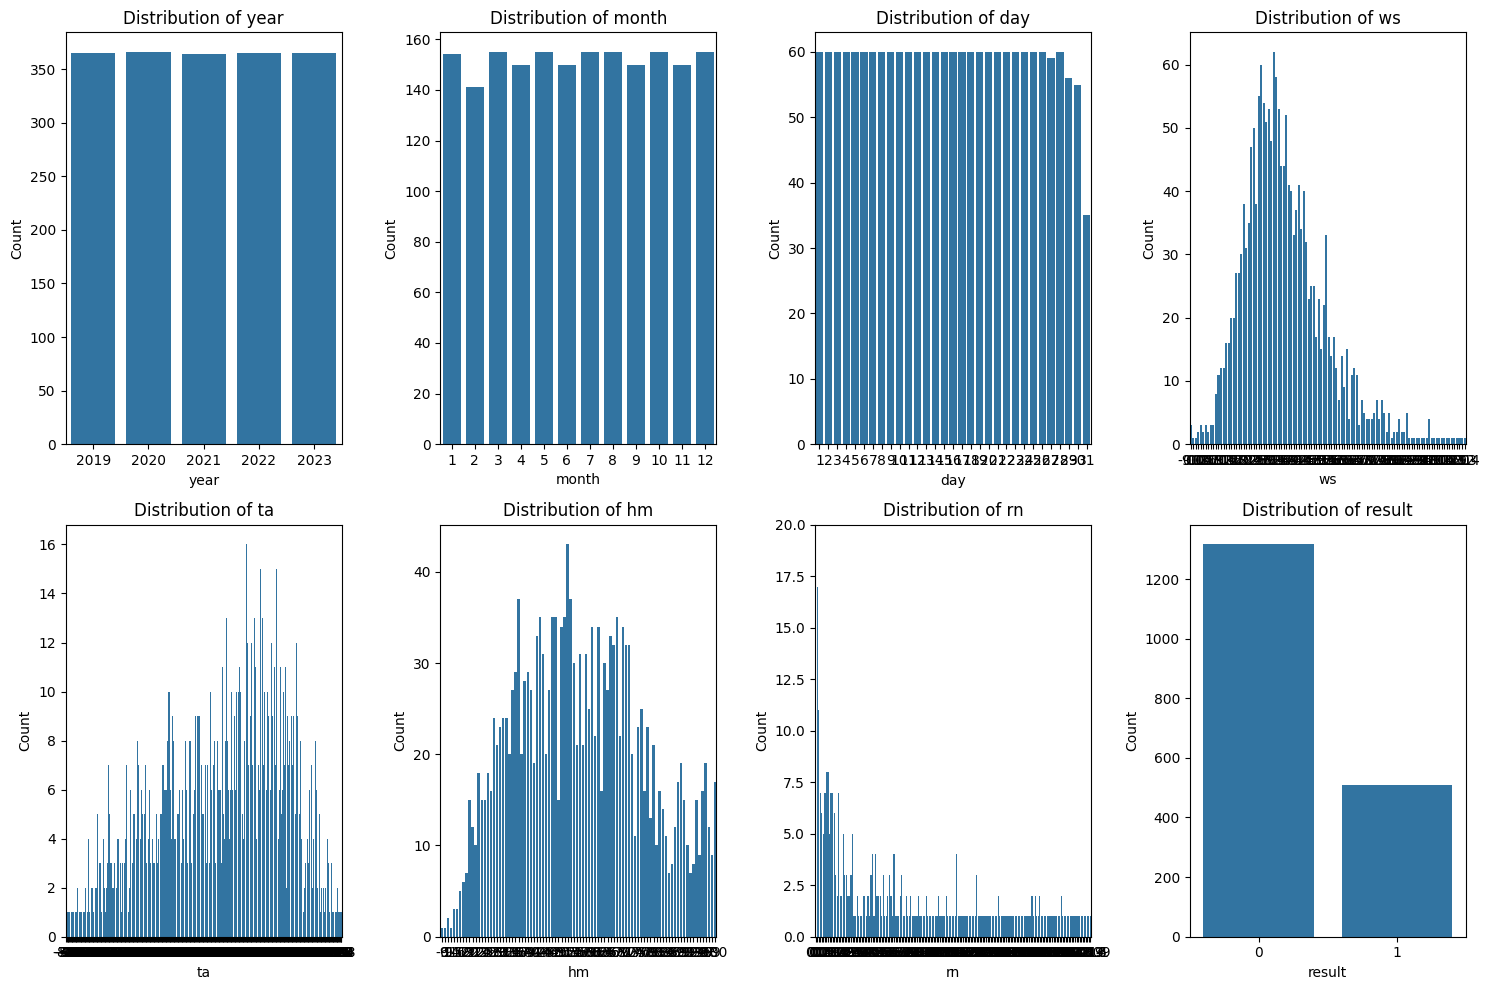

In [5]:
# 변수 리스트
columns_to_plot = ['year', 'month', 'day', 'ws', 'ta', 'hm', 'rn', 'result']
# 바플롯 시각화
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 4, i + 1)
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # rn의 y축 범위 조정
    if column == 'rn':
        plt.ylim(0, 20)  # y축 범위를 0에서 5로 설정

plt.tight_layout()
plt.show()

# 3. 데이터 전처리
- 날짜 정보 원-핫 인코딩

In [6]:
# 원핫 인코딩 수행
# year에 2024년 값을 추가할 것을 대비해 2019~2024년을 미리 열로 생성
years = [2019, 2020, 2021, 2022, 2023, 2024]
for year in years:
    df[f'year_{year}'] = (df['year'] == year).astype(int)
    
df_encoded = pd.get_dummies(df, columns=['month', 'day'], prefix=['month', 'day']).drop(columns=['year'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 54 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ws         1825 non-null   float64
 1   ta         1825 non-null   float64
 2   hm         1825 non-null   int64  
 3   rn         1825 non-null   float64
 4   result     1825 non-null   int64  
 5   year_2019  1825 non-null   int32  
 6   year_2020  1825 non-null   int32  
 7   year_2021  1825 non-null   int32  
 8   year_2022  1825 non-null   int32  
 9   year_2023  1825 non-null   int32  
 10  year_2024  1825 non-null   int32  
 11  month_1    1825 non-null   bool   
 12  month_2    1825 non-null   bool   
 13  month_3    1825 non-null   bool   
 14  month_4    1825 non-null   bool   
 15  month_5    1825 non-null   bool   
 16  month_6    1825 non-null   bool   
 17  month_7    1825 non-null   bool   
 18  month_8    1825 non-null   bool   
 19  month_9    1825 non-null   bool   
 20  month_10

# 4. 특징과 레이블 선택

In [7]:
X = df_encoded.drop(columns=['result'])  # result 열을 제외한 모든 열
y = df_encoded['result']  # 레이블

# 5. 데이터 분할
(훈련/테스트 세트, 비율: 80:20) 

In [8]:
# 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# y_train의 비율 출력
y_train_ratio = y_train.value_counts(normalize=True)
print("y_train의 비율:")
print(y_train_ratio)

y_train의 비율:
result
0    0.721233
1    0.278767
Name: proportion, dtype: float64


# 6. 모델 생성 및 학습

In [10]:
from catboost import CatBoostClassifier

In [11]:
# CatBoost 모델 생성 및 학습
model = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
model.fit(X_train, y_train)

# 7. 예측 및 평가

In [12]:
y_val_pred = model.predict(X_test)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, y_val_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("검증 세트 보고서:\n", classification_report(y_test, y_val_pred))

검증 세트 정확도: 0.7178082191780822
검증 세트 ROC AUC 점수: 0.5949824796838887
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83       263
           1       0.48      0.12      0.19       102

    accuracy                           0.72       365
   macro avg       0.61      0.53      0.51       365
weighted avg       0.66      0.72      0.65       365



In [13]:
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # 양성 클래스에 대한 확률

# 7. 테스트 세트와 예측 결과 출력
test_results = pd.DataFrame({
    '정답': y_test,
    '예측': y_test_pred,
    '예측 확률': y_test_pred_proba,
    # '날짜': pd.to_datetime(X_test[['year', 'month', 'day']]).dt.strftime('%Y-%m-%d'),
    '풍속 (ws)': X_test['ws'].values,
    '기온 (ta)': X_test['ta'].values,
    '습도 (hm)': X_test['hm'].values,
    '일일강수량 (rn)': X_test['rn'].values
})

In [14]:
print("\n테스트 세트 결과:")
test_results.sample(15)


테스트 세트 결과:


,정답,예측,예측 확률,풍속 (ws),기온 (ta),습도 (hm),일일강수량 (rn)
1497,0,0,0.211859,2.1,14.7,48,0.0
180,1,0,0.172029,3.1,25.2,75,0.4
905,0,0,0.169843,4.0,24.3,71,0.0
1556,0,0,0.126634,3.0,16.9,35,4.4
816,1,0,0.305546,6.8,15.9,62,0.6
1527,1,0,0.169916,4.3,17.5,66,0.7
1557,0,0,0.177957,3.6,14.6,29,0.0
1551,0,0,0.188218,4.3,20.8,37,0.0
882,0,0,0.481393,2.9,25.2,63,0.0
683,0,0,0.259270,2.5,20.9,50,0.0


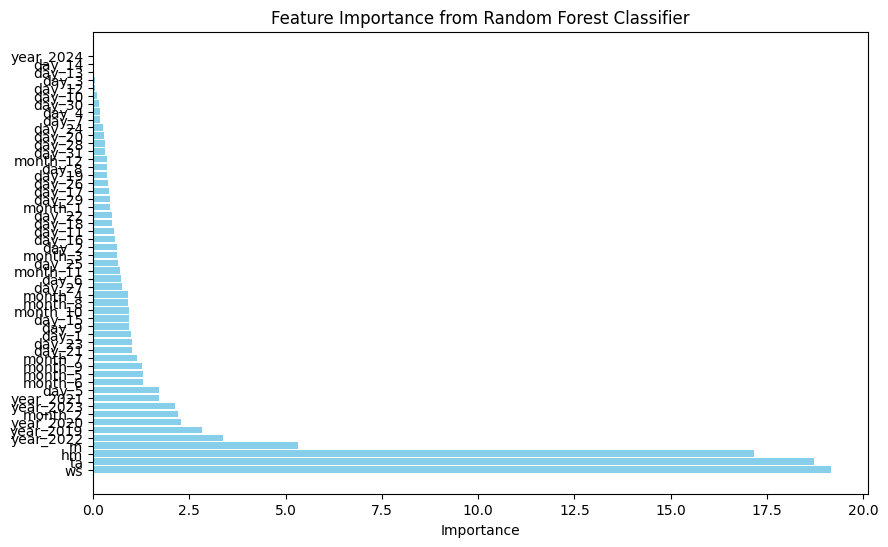

In [15]:
# 특성 중요도 가져오기
importances = model.feature_importances_

# 피처 이름과 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()